In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestRegressor


# Task 1: Understanding the Dataset
def dataset_overview(data):
    """Perform detailed statistical analysis of the dataset"""
    print("Dataset Overview:")
    
    # Unique values in each column
    for column in data.columns:
        print(f"\n{column}:")
        print(f"Unique values: {data[column].nunique()}")
    
    # Statistical analysis of numerical columns
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    print("\nNumerical Columns Statistical Analysis:")
    print(data[numerical_columns].describe(percentiles=[0.25, 0.5, 0.75]))

# Task 2: Correlation Analysis and Column Dropping
def drop_irrelevant_columns(data):
    """Remove columns with low correlation to target variable"""
    # Select numerical columns only
    numerical_data = data.select_dtypes(include=['int64', 'float64'])
    
    # Calculate correlation with target variable (Price)
    if 'Price' in numerical_data:
        correlation = numerical_data.corr()['Price'].abs()
        
        # Drop columns with low correlation
        columns_to_drop = correlation[(correlation < 0.1)].index.tolist()
        
        print("\nColumns to be dropped due to low correlation:")
        for col in columns_to_drop:
            print(f"{col}: Correlation = {correlation[col]}")
        
        return data.drop(columns=columns_to_drop)
    else:
        print("Target variable 'Price' is missing in the dataset!")
        return data

# Task 3: Encoding Categorical Features
def encode_categorical_features(data):
    """Perform label or one-hot encoding on categorical columns"""
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    print("\nEncoding Categorical Features:")
    for col in categorical_columns:
        cardinality = data[col].nunique()
        print(f"{col}: Cardinality = {cardinality}")
        
        if cardinality > 10:
            # Use one-hot encoding for high cardinality
            print(f"Using one-hot encoding for {col} due to high cardinality")
            data = pd.get_dummies(data, columns=[col], drop_first=True)
        else:
            # Label encoding for low cardinality
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
    
    return data

# Task 5: Target Variable Distribution and Binning
def analyze_target_distribution(data):
    """Analyze and categorize target variable into price brackets"""
    # Plot distribution of prices
    plt.figure(figsize=(10, 6))
    data['Price'].hist(bins=50)
    plt.title('Distribution of Property Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()
    
    # Create price brackets
    price_brackets = pd.cut(data['Price'], 
                             bins=4, 
                             labels=['Low', 'Medium', 'High', 'Very High'])
    
    # Analyze distribution of price brackets
    bracket_distribution = price_brackets.value_counts()
    print("\nPrice Bracket Distribution:")
    print(bracket_distribution)
    
    # Visualize price bracket distribution
    plt.figure(figsize=(10, 6))
    bracket_distribution.plot(kind='bar')
    plt.title('Distribution of Price Brackets')
    plt.xlabel('Price Bracket')
    plt.ylabel('Number of Properties')
    plt.show()
    
    return price_brackets

# Task 6: Handling Imbalanced Data
def handle_imbalanced_data(X, y):
    """Apply random oversampling and undersampling techniques"""
    # Random Oversampling
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    
    # Random Undersampling
    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X, y)
    
    print("\nOriginal dataset shape:", X.shape)
    print("Oversampled dataset shape:", X_ros.shape)
    print("Undersampled dataset shape:", X_rus.shape)
    
    return X_ros, y_ros, X_rus, y_rus

# Model Training and Evaluation
def train_decision_tree(X_train, X_test, y_train, y_test):
    """Train Decision Tree Regressor and evaluate performance"""
    # Default Decision Tree
    dt_default = DecisionTreeRegressor(random_state=42)
    dt_default.fit(X_train, y_train)
    
    # Visualize Decision Tree
    plt.figure(figsize=(20,10))
    plot_tree(dt_default, feature_names=X_train.columns, filled=True, rounded=True)
    plt.show()
    
    # Hyperparameter Tuning
    param_grid = {
        'max_depth': [3, 5, 7, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt']
    }
    
    grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), 
                                param_grid, 
                                cv=5, 
                                scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_dt = grid_search.best_estimator_
    print("\nBest Hyperparameters:")
    print(grid_search.best_params_)
    
    # Feature Importance
    plt.figure(figsize=(10, 6))
    feature_importance = best_dt.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    
    # Model Evaluation
    y_train_pred = best_dt.predict(X_train)
    y_test_pred = best_dt.predict(X_test)
    
    print("\nTraining Performance:")
    print("MSE:", mean_squared_error(y_train, y_train_pred))
    print("MAE:", mean_absolute_error(y_train, y_train_pred))
    print("R2 Score:", r2_score(y_train, y_train_pred))
    
    print("\nTest Performance:")
    print("MSE:", mean_squared_error(y_test, y_test_pred))
    print("MAE:", mean_absolute_error(y_test, y_test_pred))
    print("R2 Score:", r2_score(y_test, y_test_pred))
    
    # Residual Analysis
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_pred, residuals)
    plt.title('Residual Plot')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    return best_dt

# Bonus: Random Forest Comparison
def train_random_forest(X_train, X_test, y_train, y_test):
    """Train Random Forest Regressor and compare with Decision Tree"""
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    print("\nRandom Forest Performance:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))
    
    return rf

# Advanced Imbalance Handling
from collections import Counter

def advanced_imbalance_techniques(X, y):
    """Compare SMOTE and ADASYN techniques."""
    # Check class distribution
    print("\nClass distribution before resampling:", Counter(y))
    
    # SMOTE with adjusted neighbors
    smote = SMOTE(random_state=42, k_neighbors=1)
    try:
        X_smote, y_smote = smote.fit_resample(X, y)
        print("\nClass distribution after SMOTE:", Counter(y_smote))
    except ValueError as e:
        print("SMOTE failed:", e)
        X_smote, y_smote = X, y

    # ADASYN
    adasyn = ADASYN(random_state=42)
    try:
        X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
        print("\nClass distribution after ADASYN:", Counter(y_adasyn))
    except ValueError as e:
        print("ADASYN failed:", e)
        X_adasyn, y_adasyn = X, y

    return X_smote, y_smote, X_adasyn, y_adasyn

# Main Execution
def main():
    # Load the datasets
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')

    # Dataset Overview
    dataset_overview(train_data)
    
    # Drop Irrelevant Columns
    train_data = drop_irrelevant_columns(train_data)
    
    # Encode Categorical Features
    train_data = encode_categorical_features(train_data)
    
    # Separate Features and Target
    X = train_data.drop('Price', axis=1)
    y = train_data['Price']
    
    # Target Distribution Analysis
    price_brackets = analyze_target_distribution(train_data)
    
    # Handle Imbalanced Data
    X_ros, y_ros, X_rus, y_rus = handle_imbalanced_data(X, y)
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale Features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

    # Residual plot example
    plt.scatter(y_pred, residuals)

    # Train Decision Tree
    best_dt = train_decision_tree(X_train, X_test, y_train, y_test)
    
    # Random Forest Comparison
    train_random_forest(X_train, X_test, y_train, y_test)
    
    # Pruning example
    dt = DecisionTreeRegressor(random_state=42, ccp_alpha=0.01)
    dt.fit(X_train, y_train)

    # Advanced Imbalance Techniques
    X_smote, y_smote, X_adasyn, y_adasyn = advanced_imbalance_techniques(X, y)

if __name__ == "__main__":
    main()

In [8]:

# Task 2: Correlation Analysis and Column Dropping
def drop_irrelevant_columns(data):
    """Remove columns with low correlation to target variable"""
    # Select numerical columns only
    numerical_data = data.select_dtypes(include=['int64', 'float64'])
    
    # Calculate correlation with target variable (Price)
    if 'Price' in numerical_data:
        correlation = numerical_data.corr()['Price'].abs()
        
        # Drop columns with low correlation
        columns_to_drop = correlation[(correlation < 0.1)].index.tolist()
        
        print("\nColumns to be dropped due to low correlation:")
        for col in columns_to_drop:
            print(f"{col}: Correlation = {correlation[col]}")
        
        return data.drop(columns=columns_to_drop)
    else:
        print("Target variable 'Price' is missing in the dataset!")
        return data


In [9]:

# Task 3: Encoding Categorical Features
def encode_categorical_features(data):
    """Perform label or one-hot encoding on categorical columns"""
    categorical_columns = data.select_dtypes(include=['object']).columns
    
    print("\nEncoding Categorical Features:")
    for col in categorical_columns:
        cardinality = data[col].nunique()
        print(f"{col}: Cardinality = {cardinality}")
        
        if cardinality > 10:
            # Use one-hot encoding for high cardinality
            print(f"Using one-hot encoding for {col} due to high cardinality")
            data = pd.get_dummies(data, columns=[col], drop_first=True)
        else:
            # Label encoding for low cardinality
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col].astype(str))
    
    return data


In [10]:

# Task 5: Target Variable Distribution and Binning
def analyze_target_distribution(data):
    """Analyze and categorize target variable into price brackets"""
    # Plot distribution of prices
    plt.figure(figsize=(10, 6))
    data['Price'].hist(bins=50)
    plt.title('Distribution of Property Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()
    
    # Create price brackets
    price_brackets = pd.cut(data['Price'], 
                             bins=4, 
                             labels=['Low', 'Medium', 'High', 'Very High'])
    
    # Analyze distribution of price brackets
    bracket_distribution = price_brackets.value_counts()
    print("\nPrice Bracket Distribution:")
    print(bracket_distribution)
    
    # Visualize price bracket distribution
    plt.figure(figsize=(10, 6))
    bracket_distribution.plot(kind='bar')
    plt.title('Distribution of Price Brackets')
    plt.xlabel('Price Bracket')
    plt.ylabel('Number of Properties')
    plt.show()
    
    return price_brackets


In [11]:

# Task 6: Handling Imbalanced Data
def handle_imbalanced_data(X, y):
    """Apply random oversampling and undersampling techniques"""
    # Random Oversampling
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    
    # Random Undersampling
    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X, y)
    
    print("\nOriginal dataset shape:", X.shape)
    print("Oversampled dataset shape:", X_ros.shape)
    print("Undersampled dataset shape:", X_rus.shape)
    
    return X_ros, y_ros, X_rus, y_rus


In [13]:

# Bonus: Random Forest Comparison
def train_random_forest(X_train, X_test, y_train, y_test):
    """Train Random Forest Regressor and compare with Decision Tree"""
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    
    print("\nRandom Forest Performance:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))
    
    return rf


In [14]:

# Advanced Imbalance Handling
from collections import Counter

def advanced_imbalance_techniques(X, y):
    """Compare SMOTE and ADASYN techniques."""
    # Check class distribution
    print("\nClass distribution before resampling:", Counter(y))
    
    # SMOTE with adjusted neighbors
    smote = SMOTE(random_state=42, k_neighbors=1)
    try:
        X_smote, y_smote = smote.fit_resample(X, y)
        print("\nClass distribution after SMOTE:", Counter(y_smote))
    except ValueError as e:
        print("SMOTE failed:", e)
        X_smote, y_smote = X, y

    # ADASYN
    adasyn = ADASYN(random_state=42)
    try:
        X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
        print("\nClass distribution after ADASYN:", Counter(y_adasyn))
    except ValueError as e:
        print("ADASYN failed:", e)
        X_adasyn, y_adasyn = X, y

    return X_smote, y_smote, X_adasyn, y_adasyn


In [15]:

# Main Execution

# Load the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Dataset Overview
dataset_overview(train_data)


Dataset Overview:

index:
Unique values: 6256

Address:
Unique values: 3223

Possesion:
Unique values: 1

Furnishing:
Unique values: 3

Buildup_area:
Unique values: 944

Carpet_area:
Unique values: 2520

Bathrooms:
Unique values: 85

Property_age:
Unique values: 46

Parking:
Unique values: 10

Price:
Unique values: 755

Brokerage:
Unique values: 1517

Floor:
Unique values: 125

Per_sqft_price:
Unique values: 2501

BHK:
Unique values: 9

Total_bedrooms:
Unique values: 27

Numerical Columns Statistical Analysis:
             index  Buildup_area   Carpet_area    Bathrooms  Property_age  \
count  6256.000000   6256.000000   6256.000000  6256.000000   6256.000000   
mean   4879.818894   1120.690537    864.869801     1.968057      7.519661   
std    2770.439333    735.147038    583.283918     0.911779      7.374092   
min       1.000000    180.000000    150.000000     1.000000      1.000000   
25%    2494.750000    650.000000    475.000000     1.000000      2.000000   
50%    4920.500000    

In [16]:

# Drop Irrelevant Columns
train_data = drop_irrelevant_columns(train_data)



Columns to be dropped due to low correlation:
index: Correlation = 0.05361892125782141
Property_age: Correlation = 0.06961251887721583


In [17]:

# Encode Categorical Features
train_data = encode_categorical_features(train_data)



Encoding Categorical Features:
Address: Cardinality = 3223
Using one-hot encoding for Address due to high cardinality
Possesion: Cardinality = 1
Furnishing: Cardinality = 3


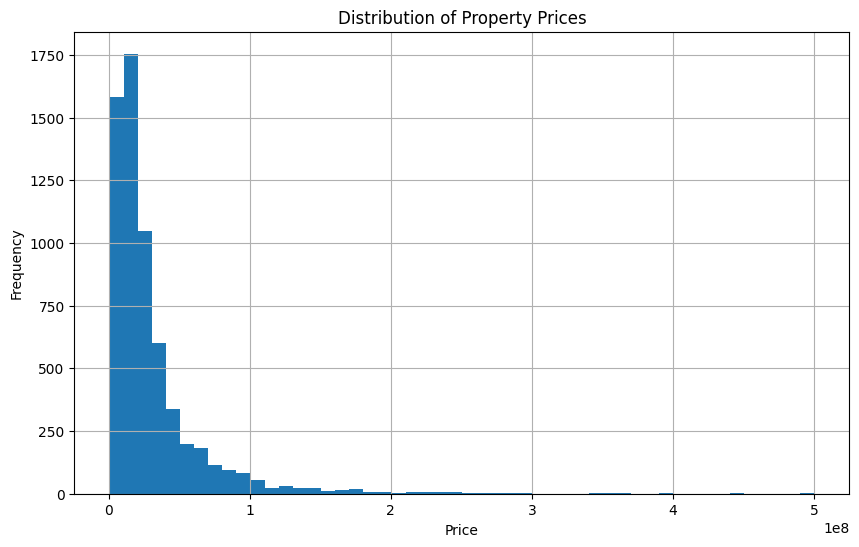


Price Bracket Distribution:
Low          6092
Medium        139
High           18
Very High       7
Name: Price, dtype: int64


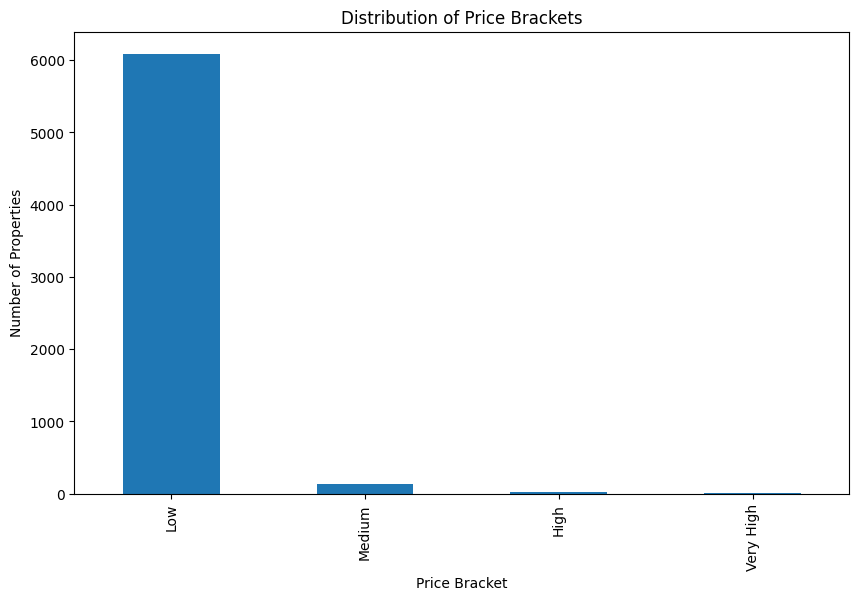


Original dataset shape: (6256, 3233)
Oversampled dataset shape: (77010, 3233)
Undersampled dataset shape: (755, 3233)


In [18]:

# Separate Features and Target
X = train_data.drop('Price', axis=1)
y = train_data['Price']

# Target Distribution Analysis
price_brackets = analyze_target_distribution(train_data)

# Handle Imbalanced Data
X_ros, y_ros, X_rus, y_rus = handle_imbalanced_data(X, y)


In [19]:

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)



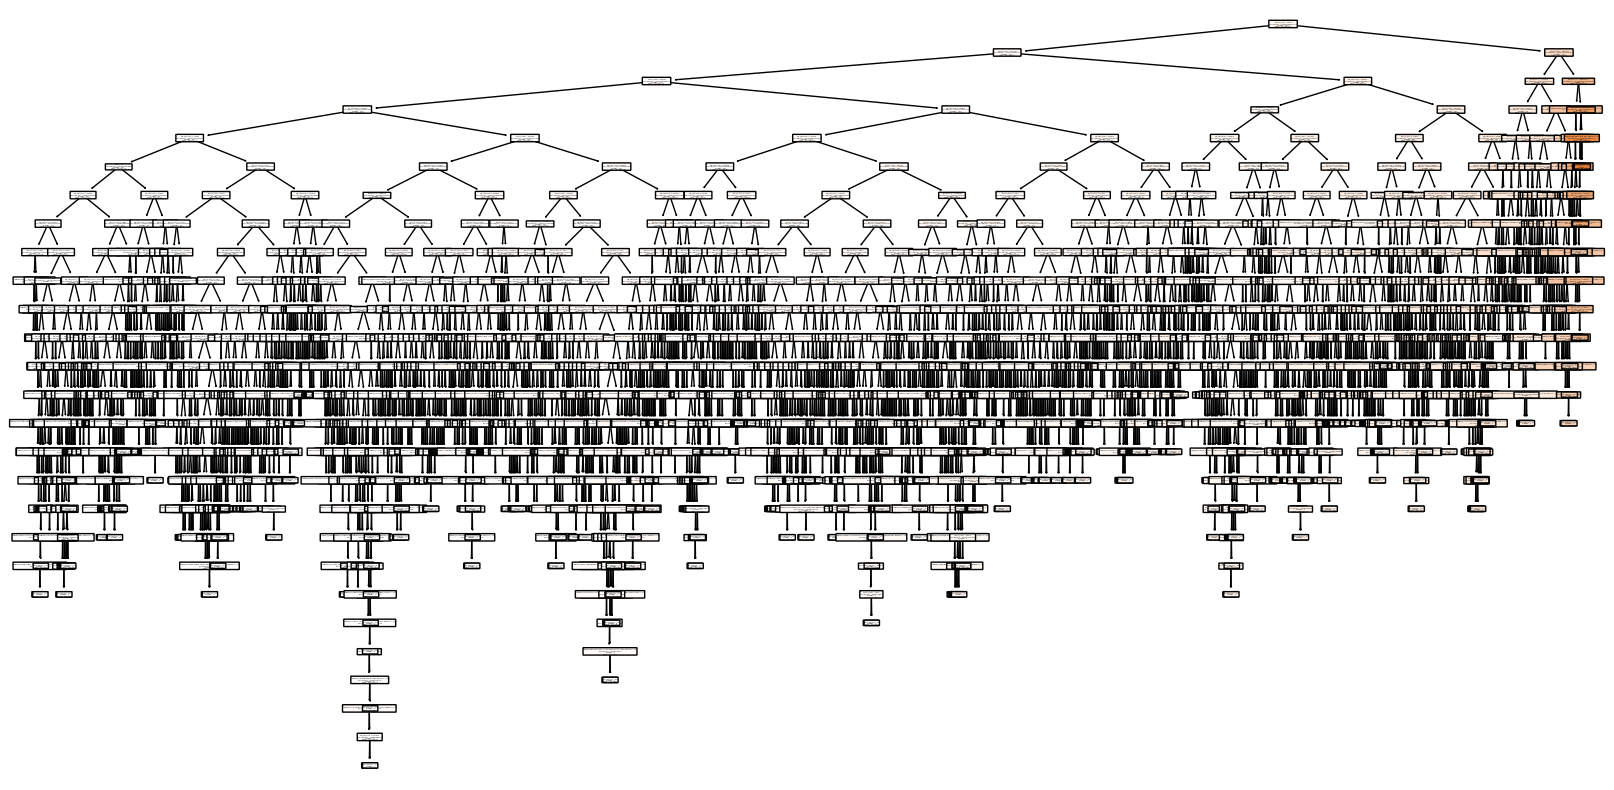


Best Hyperparameters:
{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2}


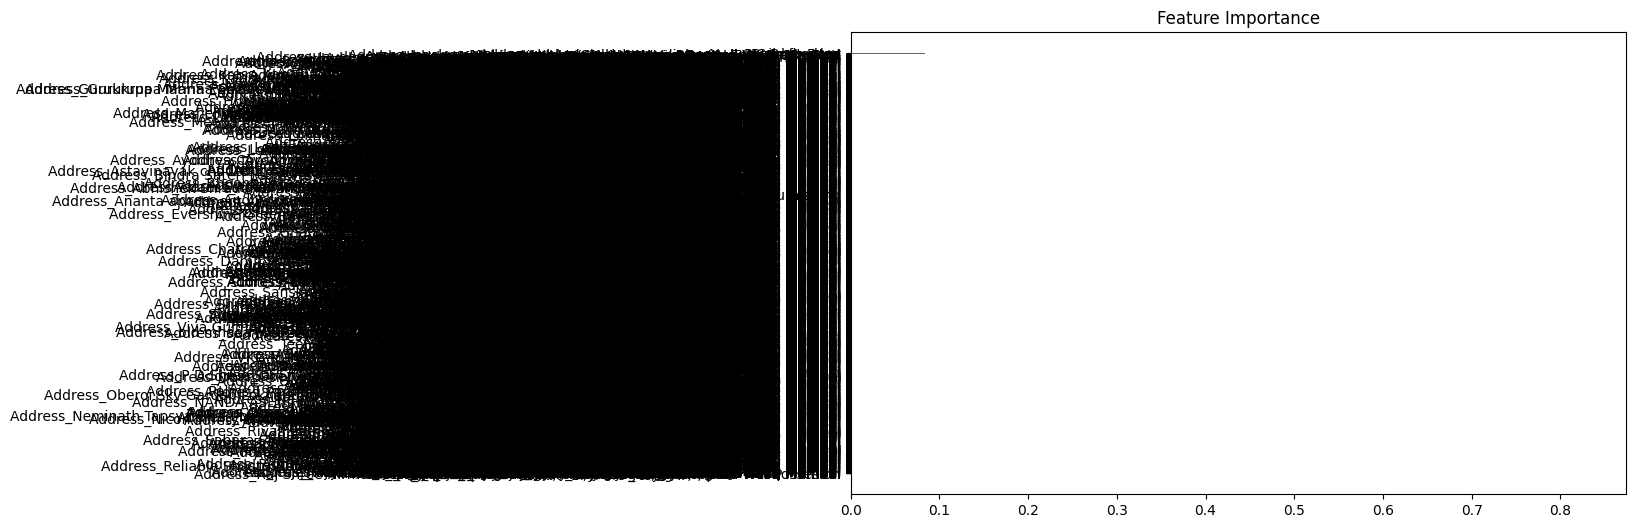


Training Performance:
MSE: 20226977033674.23
MAE: 1378354.476937947
R2 Score: 0.9863229736332574

Test Performance:
MSE: 74794510018678.78
MAE: 2172711.147538329
R2 Score: 0.9409287484762231


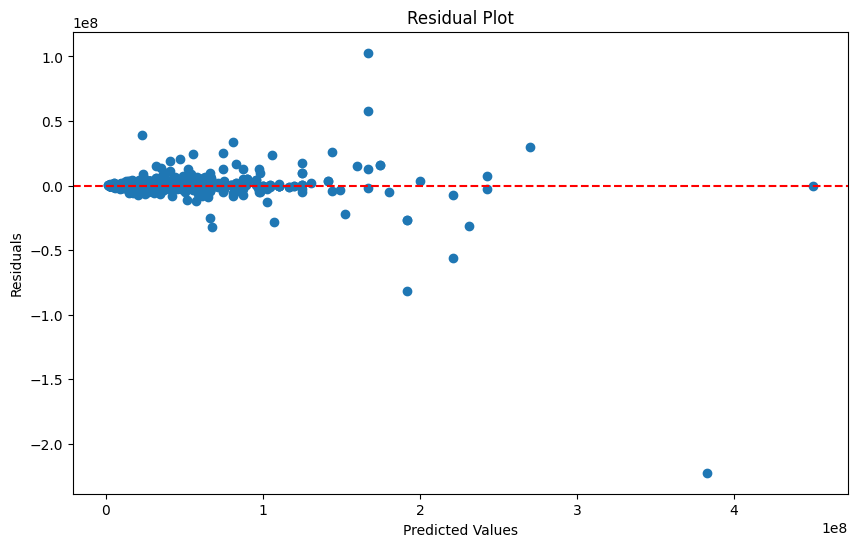


Random Forest Performance:
MSE: 20123444838558.707
MAE: 1062194.3530351438
R2 Score: 0.9841068940583141

Class distribution before resampling: Counter({12500000: 102, 17000000: 91, 17500000: 89, 22500000: 87, 21000000: 87, 20000000: 86, 10500000: 86, 25000000: 83, 11000000: 82, 12000000: 73, 10000000: 72, 11500000: 72, 16000000: 70, 13000000: 70, 18000000: 70, 14000000: 68, 35000000: 65, 19000000: 64, 45000000: 63, 18500000: 61, 19500000: 59, 9500000: 58, 16500000: 55, 30000000: 55, 9000000: 54, 22000000: 54, 15000000: 52, 24000000: 52, 15500000: 52, 6500000: 52, 21500000: 51, 14500000: 50, 13500000: 50, 27000000: 48, 8500000: 47, 31000000: 46, 26500000: 46, 40000000: 45, 28000000: 44, 7000000: 43, 32500000: 42, 70000000: 40, 3000000: 40, 27500000: 40, 23500000: 38, 65000000: 38, 33000000: 37, 26000000: 36, 60000000: 36, 85000000: 35, 7500000: 35, 37500000: 35, 55000000: 34, 50000000: 34, 42500000: 33, 28500000: 33, 9800000: 32, 31500000: 32, 32000000: 31, 23000000: 30, 100000000: 29,

In [20]:

# Train Decision Tree
best_dt = train_decision_tree(X_train, X_test, y_train, y_test)

# Random Forest Comparison
train_random_forest(X_train, X_test, y_train, y_test)

# Advanced Imbalance Techniques
X_smote, y_smote, X_adasyn, y_adasyn = advanced_imbalance_techniques(X, y)


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestRegressor
from collections import Counter


In [22]:
def dataset_overview(data):
    print("\nDataset Overview:")
    for column in data.columns:
        print(f"{column}: {data[column].nunique()} unique values")
    numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
    print("\nStatistical Analysis of Numerical Columns:")
    print(data[numerical_columns].describe(percentiles=[0.25, 0.5, 0.75]))


In [23]:
def drop_irrelevant_columns(data):
    if 'Price' in data.columns:
        correlation = data.corr()['Price'].abs()
        columns_to_drop = correlation[correlation < 0.1].index.tolist()
        print("\nDropping Columns Due to Low Correlation:", columns_to_drop)
        return data.drop(columns=columns_to_drop)
    return data


In [24]:
def encode_categorical_features(data):
    categorical_columns = data.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if data[col].nunique() > 10:
            data = pd.get_dummies(data, columns=[col], drop_first=True)
        else:
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
    return data


In [25]:
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train_scaled, X_test_scaled


In [26]:
def analyze_target_distribution(data):
    plt.hist(data['Price'], bins=50)
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()
    data['Price Bracket'] = pd.cut(data['Price'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])
    bracket_counts = data['Price Bracket'].value_counts()
    bracket_counts.plot(kind='bar', title='Price Bracket Distribution')
    plt.xlabel('Bracket')
    plt.ylabel('Count')
    plt.show()
    return data


In [27]:
def handle_imbalanced_data(X, y):
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X, y)
    print("\nOversampled Shape:", X_ros.shape, "\nUndersampled Shape:", X_rus.shape)
    return X_ros, y_ros, X_rus, y_rus


In [28]:
def train_decision_tree(X_train, X_test, y_train, y_test):
    dt = DecisionTreeRegressor(random_state=42)
    dt.fit(X_train, y_train)
    plt.figure(figsize=(15, 8))
    plot_tree(dt, feature_names=X_train.columns, filled=True, rounded=True)
    plt.show()
    y_pred = dt.predict(X_test)
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))
    return dt


In [29]:
def train_random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print("Random Forest MSE:", mean_squared_error(y_test, y_pred))
    print("Random Forest MAE:", mean_absolute_error(y_test, y_pred))
    print("Random Forest R2 Score:", r2_score(y_test, y_pred))
    return rf


In [32]:
def advanced_imbalance_techniques(X, y):
    smote = SMOTE(random_state=42, k_neighbors=1)
    X_smote, y_smote = smote.fit_resample(X, y)
    adasyn = ADASYN(random_state=42)
    X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
    print("SMOTE Class Distribution:", Counter(y_smote))
    print("ADASYN Class Distribution:", Counter(y_adasyn))
    return X_smote, y_smote, X_adasyn, y_adasyn



Dataset Overview:
index: 6256 unique values
Address: 3223 unique values
Possesion: 1 unique values
Furnishing: 3 unique values
Buildup_area: 944 unique values
Carpet_area: 2520 unique values
Bathrooms: 85 unique values
Property_age: 46 unique values
Parking: 10 unique values
Price: 755 unique values
Brokerage: 1517 unique values
Floor: 125 unique values
Per_sqft_price: 2501 unique values
BHK: 9 unique values
Total_bedrooms: 27 unique values

Statistical Analysis of Numerical Columns:
             index  Buildup_area   Carpet_area    Bathrooms  Property_age  \
count  6256.000000   6256.000000   6256.000000  6256.000000   6256.000000   
mean   4879.818894   1120.690537    864.869801     1.968057      7.519661   
std    2770.439333    735.147038    583.283918     0.911779      7.374092   
min       1.000000    180.000000    150.000000     1.000000      1.000000   
25%    2494.750000    650.000000    475.000000     1.000000      2.000000   
50%    4920.500000    950.000000    708.315583  

/var/folders/wd/p8rd_3q56c3gyt1n_mf2kh8h0000gn/T/ipykernel_19217/516832418.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = data.corr()['Price'].abs()


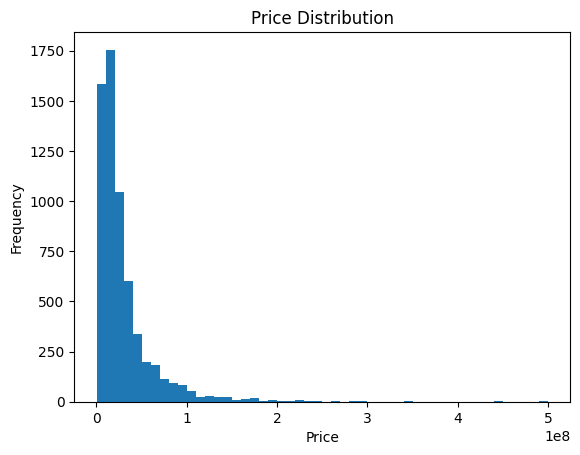

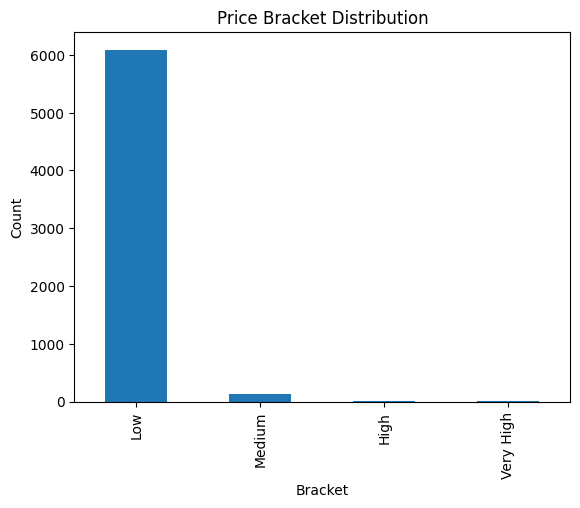

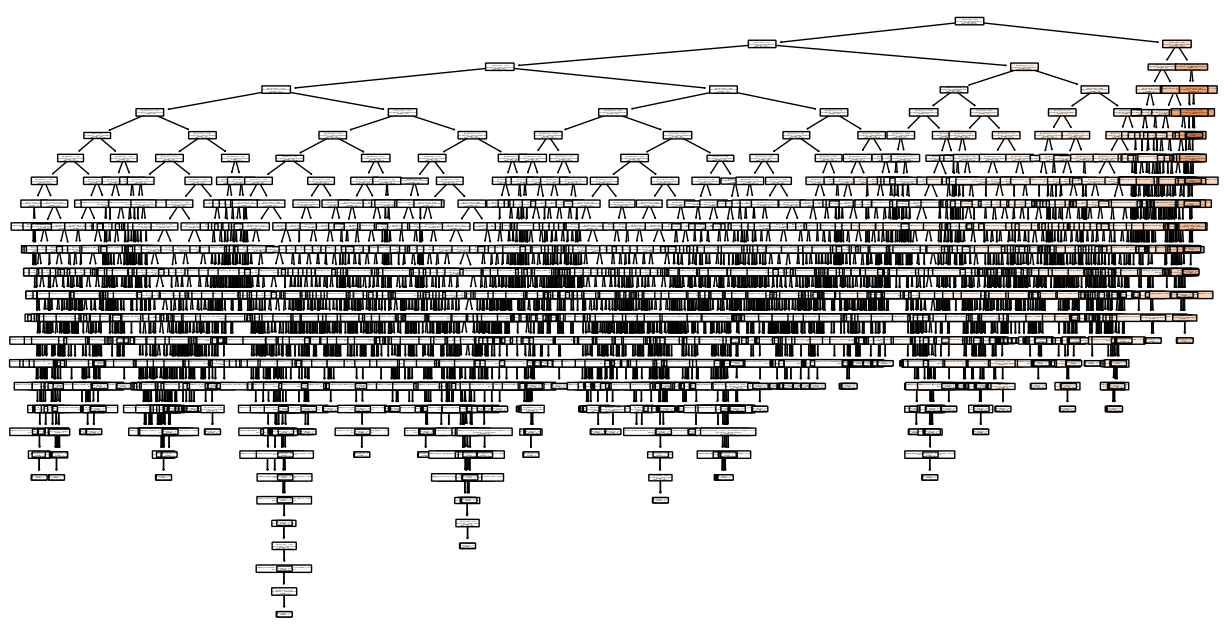

MSE: 27004128243011.184
MAE: 1285593.051118211
R2 Score: 0.9786726639264717
Random Forest MSE: 19852401398903.73
Random Forest MAE: 1041498.6522231098
Random Forest R2 Score: 0.9843209589033639


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 2

In [33]:
def main():
    train_data = pd.read_csv('train.csv')
    test_data = pd.read_csv('test.csv')
    dataset_overview(train_data)
    train_data = drop_irrelevant_columns(train_data)
    train_data = encode_categorical_features(train_data)
    X = train_data.drop(['Price'], axis=1)
    y = train_data['Price']
    analyze_target_distribution(train_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)
    train_decision_tree(X_train_scaled, X_test_scaled, y_train, y_test)
    train_random_forest(X_train_scaled, X_test_scaled, y_train, y_test)
    advanced_imbalance_techniques(X, y)

if __name__ == "__main__":
    main()
